https://www.kdnuggets.com/2023/08/leveraging-xgboost-timeseries-forecasting.html#:~:text=Often%20the%20use%20cases%20are,XGBoost%20can%20also%20be%20extended

https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import statsmodels.graphics as sg

import itertools

from sklearn.model_selection import GridSearchCV


import matplotlib.pylab as plt

import seaborn as sns
sns.set_theme()

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as st


from sklearn import metrics 

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from IPython.display import display, clear_output

%matplotlib inline

In [2]:
df = pd.read_csv('../data/nts.csv', index_col=0, parse_dates=True)
df.shape, df.columns

((42, 14),
 Index(['rynek', 'inflacja_r', 'inflacja_q', 'stopa_procentowa',
        'liczba_kredytow', 'tempo_wzrostu', 'ufnosc', 'duze_zakupy',
        'bezrobocie', 'spr_detaliczna', 'pkb', 'wynag', 'inflacja_q_kum',
        'ogolem'],
       dtype='object'))

In [200]:
df["quarter"] = pd.PeriodIndex(df.index, freq='Q').map(lambda r: int(str(r)[-1]))

drugiej połowie 2023 wynika z uruchomienia rządowego programu kredytów z preferencyjnym oprocentowaniem Bezpieczny Kredyt 2% (program był aktywny w okresie 01-07-2023 do 31-12-2023)

In [3]:
df["rpk"] = 0
df.loc[dt.datetime(year=2023, month=7, day=1): dt.datetime(year=2024, month=1, day=1), "rpk"] =1
df.rpk

2014-03-31    0
2014-06-30    0
2014-09-30    0
2014-12-31    0
2015-03-31    0
2015-06-30    0
2015-09-30    0
2015-12-31    0
2016-03-31    0
2016-06-30    0
2016-09-30    0
2016-12-31    0
2017-03-31    0
2017-06-30    0
2017-09-30    0
2017-12-31    0
2018-03-31    0
2018-06-30    0
2018-09-30    0
2018-12-31    0
2019-03-31    0
2019-06-30    0
2019-09-30    0
2019-12-31    0
2020-03-31    0
2020-06-30    0
2020-09-30    0
2020-12-31    0
2021-03-31    0
2021-06-30    0
2021-09-30    0
2021-12-31    0
2022-03-31    0
2022-06-30    0
2022-09-30    0
2022-12-31    0
2023-03-31    0
2023-06-30    0
2023-09-30    1
2023-12-31    1
2024-03-31    0
2024-06-30    0
Name: rpk, dtype: int64

In [4]:
df.head()

,rynek,inflacja_r,inflacja_q,stopa_procentowa,liczba_kredytow,tempo_wzrostu,ufnosc,duze_zakupy,bezrobocie,spr_detaliczna,pkb,wynag,inflacja_q_kum,ogolem,rpk
2014-03-31,6193.211456,100.6,100.2,0.0446,41942.0,104.2,-20.5,-16.3,13.5,105.5,103.8,3882.041728,1.000000,11854.000000,0
2014-06-30,6227.984614,100.3,100.0,0.0447,45499.0,104.1,-16.8,-15.0,12.0,105.1,103.9,3922.805136,1.002000,10285.333333,0
2014-09-30,6357.260998,99.7,99.5,0.0443,43653.0,103.3,-16.9,-12.7,11.5,102.6,104.2,3948.311807,1.002000,11241.333333,0
2014-12-31,6438.874574,99.3,99.6,0.0388,42993.0,103.3,-13.8,-10.7,11.4,103.7,103.9,3986.074690,0.996990,14341.333333,0
2015-03-31,6473.616559,98.5,99.5,0.0348,42169.0,104.0,-14.9,-11.5,11.5,104.4,104.3,4028.086865,0.993002,10567.666667,0


In [21]:
bn, fn = 35, 42
train, test = df.iloc[:bn], df.iloc[bn:fn]
train.index, test.index, len(train), len(test)

(DatetimeIndex(['2014-03-31', '2014-06-30', '2014-09-30', '2014-12-31',
                '2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
                '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-31',
                '2017-03-31', '2017-06-30', '2017-09-30', '2017-12-31',
                '2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
                '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
                '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
                '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
                '2022-03-31', '2022-06-30', '2022-09-30'],
               dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2022-12-31', '2023-03-31', '2023-06-30', '2023-09-30',
                '2023-12-31', '2024-03-31', '2024-06-30'],
               dtype='datetime64[ns]', freq=None),
 35,
 7)

In [22]:
X_train = train.drop('rynek', axis=1)
y_train = train['rynek']

X_test = test.drop('rynek', axis=1)
y_test = test['rynek']

In [29]:
reg = xgb.XGBRegressor(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=120,
    gamma=0.001
    )
reg.fit(X_train, y_train, verbose=True)
test['rynek_Prediction'] = reg.predict(X_test)

/tmp/ipykernel_98298/2677778073.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rynek_Prediction'] = reg.predict(X_test)


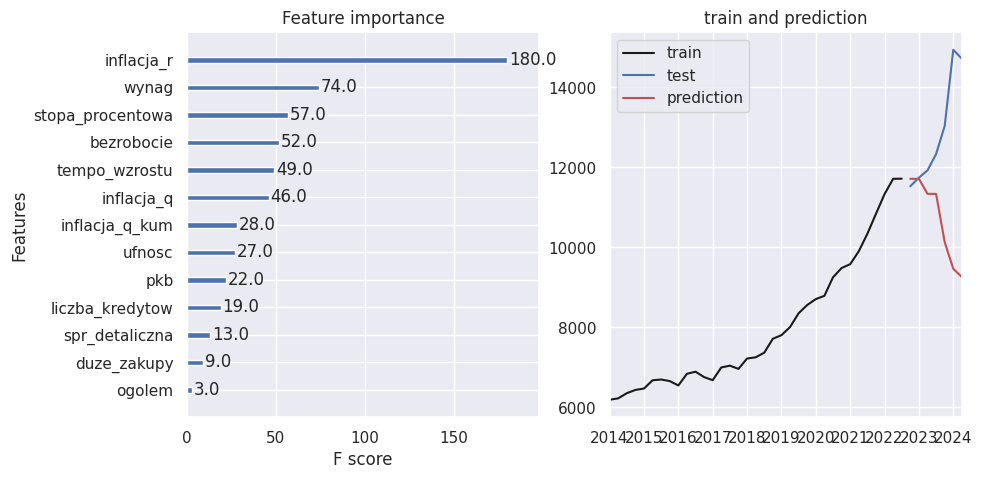

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2)
xgb.plot_importance(reg, ax=axes[0])
train['rynek'].plot(style='k', figsize=(10,5), label = 'train', ax=axes[1])
test['rynek'].plot(style='b', figsize=(10,5), label = 'test', ax=axes[1])
test['rynek_Prediction'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('train and prediction')
plt.legend()

In [25]:
test

,rynek,inflacja_r,inflacja_q,stopa_procentowa,liczba_kredytow,tempo_wzrostu,ufnosc,duze_zakupy,bezrobocie,spr_detaliczna,pkb,wynag,inflacja_q_kum,ogolem,rpk,rynek_Prediction
2022-12-31,11530.415342,117.3,103.6,0.0896,18932.0,112.0,-43.8,-39.6,5.2,100.1,102.5,6850.330727,1.322818,23829.000000,0,11717.840820
2023-03-31,11744.826140,117.0,104.3,0.0890,21968.0,113.3,-36.6,-35.9,5.4,96.5,99.5,7062.406358,1.370440,18350.333333,0,11716.749023
2023-06-30,11928.471147,113.1,101.9,0.0877,30798.0,112.2,-30.1,-32.1,5.1,92.7,99.4,7278.507128,1.429369,18936.333333,0,11342.290039
2023-09-30,12335.591393,109.7,99.7,0.0779,40749.0,110.8,-22.5,-24.5,5.0,101.4,100.5,7498.418749,1.456527,16327.666667,1,11340.712891
2023-12-31,13037.926475,106.4,100.5,0.0808,68860.0,111.5,-16.1,-18.2,5.1,99.5,101.0,7684.873442,1.452157,20138.666667,1,10133.962891
2024-03-31,14942.844839,102.8,100.9,0.0796,64504.0,112.5,-12.5,-14.1,5.3,105.0,102.1,7954.361153,1.459418,16095.333333,0,9469.150391
2024-06-30,14718.380953,102.5,101.4,0.0819,45434.0,110.9,-12.4,-12.8,4.9,104.8,103.2,8144.805614,1.472553,15776.333333,0,9264.360352


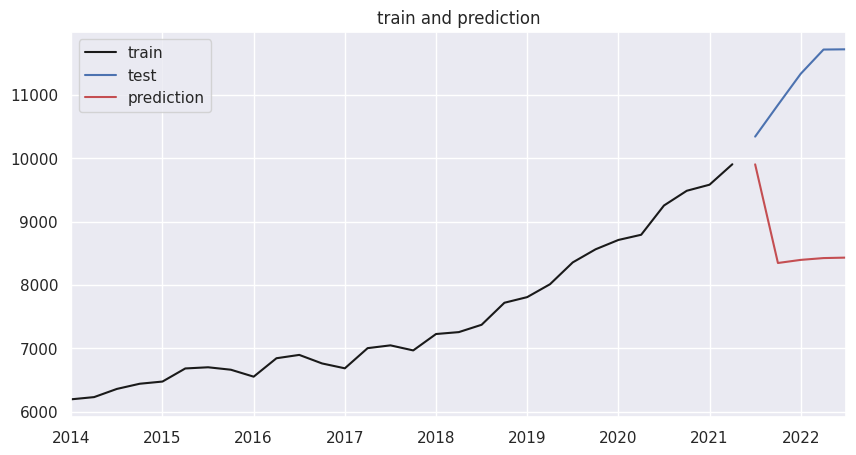

In [26]:
print('RMSE: ', round(metrics.mean_squared_error(y_true=test['rynek'],y_pred=test['rynek_Prediction']),3))
print('MAE: ', round(metrics.mean_absolute_error(y_true=test['rynek'],y_pred=test['rynek_Prediction']),3))
print('MAPE: ', round(metrics.mean_absolute_percentage_error(y_true=test['rynek'],y_pred=test['rynek_Prediction']),3))

RMSE:  9929997.757
MAE:  2232.606
MAPE:  0.158


https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d

In [194]:
param_grid = {
    'max_depth': [2, 3, 5],
    'max_leaves': [0, 3, 5, 7],
    'learning_rate': [0.3, 0.25, 0.2, 0.1, 0.05, 0.01,],
    'subsample': [0.6, 0.7, 0.8, 1],
    'n_estimators': [10, 15, 20, 120 , 240, 400]
}

In [195]:
pairs = [[(k, _v) for _v in v] for k,v in param_grid.items()]
num = np.prod([len(p) for p in pairs])
num

1728

In [196]:

pairs = [[(k, _v) for _v in v] for k,v in param_grid.items()]
num = np.prod([len(p) for p in pairs])
res = {}
counter = 0
for it in itertools.product(*pairs):
    display(str(round(counter / num, 4) * 100) + " %")
    counter += 1
    d = dict(it)
    model = xgb.XGBRegressor(**d)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = metrics.mean_squared_error(y_true=test['rynek'], y_pred=pred)
    mae = metrics.mean_absolute_error(y_true=test['rynek'], y_pred=pred)
    mape = metrics.mean_absolute_percentage_error(y_true=test['rynek'],y_pred=pred)
    res[tuple(d.values())] = (rmse, mae, mape)
    clear_output(wait=True)
    

'99.94 %'

In [197]:
for k, v in sorted(res.items(), key=lambda r: r[1][0]):
    print(k, v)
    

(2, 0, 0.3, 0.6, 15) (6162356.488940647, 2362.45210449277, 0.20829105528962186)
(2, 5, 0.3, 0.6, 15) (6162356.488940647, 2362.45210449277, 0.20829105528962186)
(2, 7, 0.3, 0.6, 15) (6162356.488940647, 2362.45210449277, 0.20829105528962186)
(3, 7, 0.3, 1, 120) (6375984.655364539, 2326.81675293027, 0.20427730052070975)
(3, 7, 0.3, 1, 240) (6375984.655364539, 2326.81675293027, 0.20427730052070975)
(3, 7, 0.3, 1, 400) (6375984.655364539, 2326.81675293027, 0.20427730052070975)
(3, 0, 0.3, 1, 120) (6378844.465582101, 2327.19663574277, 0.20430973531230423)
(3, 0, 0.3, 1, 240) (6378844.465582101, 2327.19663574277, 0.20430973531230423)
(3, 0, 0.3, 1, 400) (6378844.465582101, 2327.19663574277, 0.20430973531230423)
(3, 0, 0.3, 1, 20) (6433871.17257371, 2351.87202636777, 0.2066610408080412)
(3, 7, 0.3, 1, 20) (6433871.17257371, 2351.87202636777, 0.2066610408080412)
(5, 0, 0.3, 1, 15) (6534763.428014032, 2399.01831543027, 0.21115455412894094)
(3, 0, 0.3, 1, 10) (6549580.125124507, 2416.17554199277,

In [170]:
model = xgb.sklearn.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

/home/volodya/code/ds/pkobp/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'